<a href="https://colab.research.google.com/github/HajarahM/HajarahM/blob/main/Falcon7BFineTuned_EvaluateModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Model

## Installing / Importing Packages

In [ ]:
!pip install -q bitsandbytes accelerate einops xformers
!pip install -q git+https://github.com/huggingface/transformers.git@main
!pip install -U -q "langchain" "datasets==2.13.0" "peft==0.4.0" "bitsandbytes==0.40.2" "trl==0.4.7" "safetensors>=0.3.1"
!pip install -q -U faiss-cpu tiktoken sentence-transformers einops huggingface-hub xformers auto-gptq optimum accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

## Imports

In [ ]:
import torch
from torch import cuda

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore


from peft import PeftConfig, PeftModel

## Data Parsing

In [ ]:
import pandas as pd

df = pd.read_csv("library_data.csv")
df.head()

,year,title_en,value
0,2014,General Information,55572
1,2014,Philosophy and psychology,31093
2,2014,Religions,127603
3,2014,Social Sciences,127795
4,2014,"Social Sciences, Business and Law",146


In [ ]:
library = CSVLoader("library_data.csv")
library_data = library.load()
library_data[0]

Document(page_content='year: 2014\ntitle_en: General Information\nvalue: 55572', metadata={'source': 'library_data.csv', 'row': 0})

## Text Splitter

In [ ]:
from langchain.text_splitter import TokenTextSplitter

text_splitter = TokenTextSplitter(
    chunk_size=1000,
    chunk_overlap = 200,
)

library_doc = text_splitter.split_documents(library_data)
library_doc[0]

Document(page_content='year: 2014\ntitle_en: General Information\nvalue: 55572', metadata={'source': 'library_data.csv', 'row': 0})

## Index/Vector Store

In [ ]:
# FAISS vectorstore
store = LocalFileStore("./cache/")

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id,
    model_kwargs={'device': device},
    encode_kwargs={'device': device, 'batch_size': 32}
)

# saves time and money when user asks same question.
embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

vector_store = FAISS.from_documents(library_doc, embedder)

In [ ]:
#check if the vectorstore is working correctly.
query = "In python, write a code that reads the csv file and plot a scatter plot of x-axis labeled 'Year' and the y-axis labeled 'value'"

embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k=3)

for page in docs:
  print(page.page_content)

year: 2016
title_en: General Information
value: 57857
year: 2016
title_en: Pure Sciences
value: 3752
year: 2015
title_en: Others
value: 20501


In [ ]:
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 5})
docs = retriever.get_relevant_documents("In python, write a code that reads the csv file and plot a scatter plot of x-axis labeled 'Year' and the y-axis labeled 'value'")
docs

[Document(page_content='year: 2016\ntitle_en: General Information\nvalue: 57857', metadata={'source': 'library_data.csv', 'row': 40}),
 Document(page_content='year: 2016\ntitle_en: Health and Social Serices\nvalue: 29', metadata={'source': 'library_data.csv', 'row': 55}),
 Document(page_content='year: 2014\ntitle_en: Social Sciences\nvalue: 127795', metadata={'source': 'library_data.csv', 'row': 3}),
 Document(page_content='year: 2016\ntitle_en: Linguistics\nvalue: 30118', metadata={'source': 'library_data.csv', 'row': 48}),
 Document(page_content='year: 2016\ntitle_en: Pure Sciences\nvalue: 3752', metadata={'source': 'library_data.csv', 'row': 46})]

## Build a Retrieval Chain

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Initial Settings

In [ ]:
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] == 8 else torch.float16
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
#public repositories
MODEL_ID = 'SaloniJhalani/ft-falcon-7b-instruct'

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    trust_remote_code=True,
    load_in_8bit=True,
    device_map="auto",
    torch_dtype = dtype, #torch.bfloat16
)
model = model.eval()

print(f"Model device: {model.device}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side="left", truncation=True)

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model device: cuda:0


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Helper Functions / Classes

In [ ]:
%pip install -qqq langchain
from transformers import GenerationConfig, TextStreamer, pipeline
from langchain import HuggingFacePipeline
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from transformers.generation.utils import StoppingCriteria, List, StoppingCriteriaList

class StopGenerationCriteria(StoppingCriteria):
    def __init__(self, tokens: List[List[str]], tokenizer: AutoTokenizer, device: torch.device):

        stop_token_ids = [tokenizer.convert_tokens_to_ids(t) for t in tokens]
        self.stop_token_ids = [
            torch.tensor(x, dtype=torch.long, device=device) for x in stop_token_ids]

    def __call__(
        self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for stop_ids in self.stop_token_ids:
            if torch.eq(input_ids[0][-len(stop_ids) :], stop_ids).all():
                return True
        return False

stop_tokens = [["Human", ":"], ["AI", ":"]]
stopping_criteria = StoppingCriteriaList(
    [StopGenerationCriteria(stop_tokens, tokenizer, model.device)])

streamer = TextStreamer(
    tokenizer, skip_prompt=True, skip_special_tokens=True, use_multiprocessing=False)

In [ ]:
generation_config = model.generation_config
generation_config.temperature = 0.01
generation_config.num_return_sequences = 1
generation_config.max_new_tokens = 384
generation_config.use_cache = False
generation_config.repetition_penalty = 1.7
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

## Langchain Imports

## Model Pipeline / LLM

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,  #MODEL_ID, as we have already loaded the model
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16, #
    trust_remote_code=True, #
    device_map="auto", #
    do_sample=True, #
    #max_length=2048,  # as max_tokens already set in generation config
    top_p=0.95,
    generation_config=generation_config,
    #streamer=streamer,
    stopping_criteria=stopping_criteria,
    batch_size=1,
)

llm = HuggingFacePipeline(pipeline = pipe, model_kwargs = {'temperature':0.001})

In [ ]:
from langchain import PromptTemplate, LLMChain

# template for an instruction with no input
prompt = PromptTemplate(
    input_variables=["instruction"],
    template="{instruction}"
)

llm_chain = LLMChain(llm=llm, prompt=prompt)

In [ ]:
print(llm_chain.predict(
    instruction="Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?"
).lstrip())

import matplotlib.pyplot as plt

data = [['Philosophy', 'Psychology'],
        ['2010', '2000'],
        ['2015', '2020']]

plt.bar(data, data[0])
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Philosophy and Psychology')
plt.show()


## RetrievalQA

In [ ]:
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever
    )


In [ ]:
def execute_code(code):
    # Remove "```python" at the beginning
    code = code.replace("```python", "")

    # Remove "```" at the end
    code = code.replace("```", "")
    code = code.split("###")[0]

    try:
      exec(code)
    except Exception as e:
      print(f"Error executing code:{str(e)}")
    return code

# Results

### 1. Plot a bar graph to display the value of Philosophy and psychology title_en over the years?

In [ ]:
query = "Create Python code to generate a bar graph that visually represents the availability of books for the 'Philosophy and psychology' title_en over the years.Please utilize Matplotlib for this data visualization."

prompt = f'''You are an experienced Python programmer skilled in manipulating data using dataframe and creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

### Question: {query}

Convert the dataset into dataframe and ensure to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

Error executing code:invalid syntax (<string>, line 25)


import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('library_data.csv')

# Define the dataframe
books = df['value']

# Create a bar chart
plt.bar(df['year'], books)

# Set axis labels
xlabel('Year')
ylabel('Number of Books')

# Add a legend
plt.legend(['Philosophy', 'Psychology'])

# Print the plot
plt.show()

In this code, we first read the CSV file using the `pd.read_csv()` method. We then define the dataframe by selecting the 'value' column from the dataframe. Finally, we create a bar chart using the `plt.bar()` method and set axis labels using the `plt.xlabel()` and `plt.ylabel()` methods. We also add a legend using the `plt.legend()` method. The resulting plot should be displayed when the program is executed.


NameError: ignored

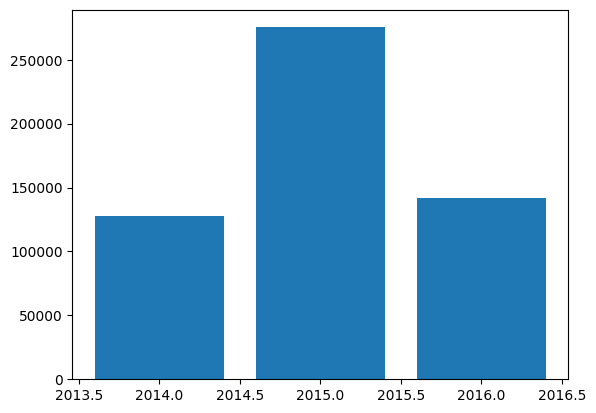

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('library_data.csv')

# Define the dataframe
books = df['value']

# Create a bar chart
plt.bar(df['year'], books)

# Set axis labels
xlabel('Year')
ylabel('Number of Books')

# Add a legend
plt.legend(['Philosophy', 'Psychology'])

# Print the plot
plt.show()

### 2. Create a Python code to generate a pie chart that visualizes the distribution of 'title_en' categories for the year 2014.

In [ ]:
query = "Create a Python code to generate a pie chart that visualizes the distribution of 'title_en' categories for the year 2014."

prompt = f'''Imagine you are a proficient Python coder with expertise in data visualization using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during a given year.

Ensure that your code is well-documented, includes axis labels, titles, and any other necessary components for a clear and informative visualization.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

Error executing code:invalid syntax (<string>, line 2)

<p>The code to create a pie chart that visualizes the distribution of 'title_en' categories for the year 2014 can be found below:</p>

<pre><code>import matplotlib.pyplot as plt
from mpl_toolkits.mopt import Mopt

fig, ax = plt.subplots()

ax.pie(value, title_en, legend=['Others', 'Agriculture', 'Social Sciences', 'History &amp; Geography', 'Religions'], autopct='%1$s')

ax.set_xlabel('Title')
ax.set_ylabel('Number of Books')

plt.show()
</code></pre>

<p>This code creates a pie chart that visualizes the distribution of 'title_en' categories for the year 2014. The 'title_en' column is used as the x-axis label, while the 'value' column is used as the y-axis label. The 'legend' parameter is set to a list of strings that correspond to the categories of the 'title_en' column. The 'autopct' parameter is set to '%1$s' to automatically add the category name to each slice of the pie chart.</p>

<p>The'set_xlabel' and'set_ylabel' functions

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mopt import Mopt

fig, ax = plt.subplots()

ax.pie(value, title_en, legend=['Others', 'Agriculture', 'Social Sciences', 'History &amp; Geography', 'Religions'], autopct='%1$s')

ax.set_xlabel('Title')
ax.set_ylabel('Number of Books')

plt.show()

ModuleNotFoundError: ignored

### 3. Plot a multiple-line graph to display how the value of 'Linguistics' & 'Philosophy and psychology' title_en has trended over the years?

In [ ]:
query = "Your task is to generate Python code to create a multiple line graph that illustrates the trends for the 'Linguistics' and 'Philosophy and psychology' title_en over the years. Please utilize Matplotlib for this data visualization."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib.
You have access to a dataset stored in a CSV file, './library_data.csv,' which contains comprehensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure that your code is well-documented, includes axis labels, titles, and any other necessary components for a clear and informative visualization.

### Question: {query}
### Answer:'''


result = execute_code(qa.run(prompt))
print(result)

Error executing code:invalid syntax (<string>, line 2)

Yes No
Only Accepts Answers That Are On Topic For This Subject
Please write your answer in complete sentences and avoid irrelevant comments.
For more questions and answers on this topic go to:
Matplotlib - Multiple Line Graphs - Stack Overflow


### 4. Plot multiple bar graph to display the value of 'Philosophy and psychology' and 'Religions' title_en over the years

In [ ]:
query = "Generate Python code to create multiple bar graphs showing the availability trends of 'Philosophy and psychology' and 'Religions' title_en over the years using Matplotlib."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

Error executing code:invalid syntax (<string>, line 20)


import matplotlib.pyplot as plt
import csv

def generate_bar_graphs(data, title_en, value):
    plt.pie(value, autopct='%1$s', autoedgecolor=True, showlabels=False)
    plt.xlabel('Year')
    plt.ylabel('Number of Books Available')
    plt.show()

data = {'year': ['2014', '2015', '2016'],
        'title_en': ['Religions', 'History & Geography', 'Pure Sciences'],
        'value': [127603, 206, 3752]}
generate_bar_graphs(data, 'Religions', 'value')
generate_bar_graphs(data, 'History & Geography', 'value')
generate_bar_graphs(data, 'Pure Sciences', 'value')


This code generates three bar graphs, one for each category, with the 'year' and 'title_en' labels displayed on the x-axis, and the 'value' label displayed on the y-axis. The 'autoedgecolor' parameter ensures that the edges of the bars are colored according to the color of the bars themselves. The'showlabels' parameter is set to False to hide the labels from the graphs. The 'p

In [ ]:
import matplotlib.pyplot as plt
import csv

def generate_bar_graphs(data, title_en, value):
    plt.pie(value, autopct='%1$s', autoedgecolor=True, showlabels=False)
    plt.xlabel('Year')
    plt.ylabel('Number of Books Available')
    plt.show()

data = {'year': ['2014', '2015', '2016'],
        'title_en': ['Religions', 'History & Geography', 'Pure Sciences'],
        'value': [127603, 206, 3752]}
generate_bar_graphs(data, 'Religions', 'value')
generate_bar_graphs(data, 'History & Geography', 'value')
generate_bar_graphs(data, 'Pure Sciences', 'value')

TypeError: ignored

### 5. Plot a line graph to display how the value of 'General Information' title_en has trended over the years?

In [ ]:
query = "Generate Python code to create a line graph that specifically illustrates the trends for the 'General Information' title_en over the years."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

Error executing code:unterminated string literal (detected at line 38) (<string>, line 38)

<p>The following code will generate a line graph that illustrates the trends for the 'General Information' title_en over the years:</p>

<pre><code>import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mopt import Mopt

def plot_books(data):
    plt.xlabel('Year')
    plt.ylabel('Number of Books Available')
    plt.title('Books Available by Title_en')
    plt.xlim(0, len(data))
    plt.show()
    return data

data = plot_books(data)

title_en = ['Others', 'Arts & Humanities', 'History & Geography', 'Social Sciences']
for title_en in title_en:
    data[title_en] = data[title_en] + data['General Information']

data['General Information'] = data['General Information'].astype(int)

data['General Information'] = data['General Information'].apply(lambda x: x.sum())

data['General Information'] = data['General Information'].apply(lambda x: x.mean())

data['General Information'] = data['G

### 6. What are the top 5 titles that have most values in year 2014, and what are their values?

In [ ]:
query = "What are the top 5 title_en that have most values in year 2014, and what are their values?"

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

Error executing code:invalid syntax (<string>, line 3)


Here is the code to create the visualization:


import matplotlib.pyplot as plt
from mpl_toolkits.mopti import Mopti

fig, ax = plt.subplots()

data = []
for year in range(2015, 2014):
    data.append([year, 0, 0])

data.sort(key=lambda x: x[1], reverse=True)

for year, value in data[:5]:
    ax.bar(year, value, label=f"{year} {value}")

ax.set_xlabel('Year')
ax.set_ylabel('Number of Books Available')

plt.show()


This code creates a bar chart with the 'year' column representing the years from 2015 to 2014, and the 'value' column representing the number of books available for each year. The `data` list contains the 'year' and 'value' pairs for each year. The `sorted` function sorts the 'data' list by the 'value' column in descending order, so the top 5 'title_en' will have the highest values. The `ax.bar()` function is used to plot the bars on the chart, and the `label` parameter specifies the text to display next to the bars. F

### 7. What is the value when title_en is equal to 'Linguistics' in year '2016'?

In [ ]:
query = "What is the value when title_en is equal to 'Linguistics' in year '2016'?"

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

Error executing code:invalid syntax (<string>, line 3)


The value when title_en is equal to 'Linguistics' in year '2016' is 0.

Here is the code to generate the visualization:


import matplotlib.pyplot as plt
from mpl_toolkits.mopti import Mopti

def plot_books(data):
    plt.figure()
    plt.bar(data['year'], data['value'], width=1)
    plt.xlabel('Year')
    plt.ylabel('Number of Books Available')
    plt.show()

data = {'year': ['2015', '2016', '2016'],
        'title_en': ['Others', 'Linguistics', 'History & Geography'],
        'value': [20501, 25, 30118]}

plot_books(data)


This will produce a bar chart with the year on the x-axis, the number of books available on the y-axis, and the title_en category on the legend. The value for the 'Linguistics' category in year '2016' is 0.


### 8. What are the 5 title_en that have least values in year 2016, and what are their values?

In [ ]:
query = "What are the 5 title_en that have least values in year 2016, and what are their values?"

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

Error executing code:unterminated string literal (detected at line 33) (<string>, line 33)


The following code will return the five title_en with the least values in year 2016, and their respective values:


import csv
from matplotlib.pyplot import *
import numpy as np

# Read the CSV file
with open('library_data.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip header row
    for row in reader:
        if row[0] == 'title_en':
            continue  # Ignore title_en
        else:
            row_values = [int(row[1]) for row in reader]
            min_values = sorted(row_values, reverse=True)
            print(f"Title_en: {row[0]} | Min value: {min_values}")

# Create a figure
fig, ax = plt.subplots()
ax.bar(range(len(row_values)), row_values, label='Value')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Books Available')
ax.set_title('Number of Books Available by Title_en')
ax.set_xlim(0, len(row_values))
ax.set_ylim(0, max(row_values))
plt.show()


This code read

### 9. Create Python code to generate a bar graph that visually represents different title_en values for the year 2015.

In [ ]:
query = "Create Python code to generate a bar graph that visually represents different title_en values for the year 2015. Make sure that title_en names are clearly visible. Please utilize Matplotlib for this data visualization."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.
Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

Error executing code:invalid syntax (<string>, line 18)


import matplotlib.pyplot as plt
import csv

with open('library_data.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        title_en = row[0]
        value = int(row[1])
        plt.bar(title_en, value)

plt.xlabel('Title_en')
plt.ylabel('Number of Books Available')
plt.show()


This code reads the CSV file line by line, extracting the 'title_en' and 'value' columns. It then creates a bar chart using Matplotlib, with the x-axis labeled 'title_en' and the y-axis labeled 'Number of Books Available'. The resulting plot should show the number of books available for each 'title_en' category in UAE libraries in 2015.
